# Basic imports and style settings

In [1]:
import numpy as np
import mdtraj as md
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
from matplotlib.colors import PowerNorm, LogNorm, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec


In [34]:
# plotting settings
# ensure all plots have white backgrounds and no transparent axes
plt.rcParams['axes.facecolor'] = 'white'


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.titlesize'] = 23
plt.rcParams['axes.labelpad'] = 15
plt.rcParams['xtick.labelsize'] = 19
plt.rcParams['ytick.labelsize'] = 19
plt.rcParams['legend.fontsize'] = 25
plt.rcParams['figure.titlesize'] = 19
plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['errorbar.capsize'] = 3.0

# Generate the landscape

In [3]:
# Seed for reproducibility
np.random.seed(230692)
# np.random.seed(270691)

# Dimensions of the energy grid
height, width = 20, 100

# Generate a random grid of energy values
energy_landscape = np.random.rand(height, width) * 100

# Path initialization
current_row = np.random.randint(height)
path_strength = 0.1  # How much to reduce the energy along the path

# Create a meandering path across the grid
for col in range(width):
    # Update the energy at the current path position
    energy_landscape[current_row, col] *= path_strength
    
    # Randomly choose the next step direction: up, down, or straight
    step = np.random.choice([-1, 0, 1])
    current_row = np.clip(current_row + step, 0, height - 1)  # Keep within bounds

# Add sharp high-energy barriers
for _ in range(30):  # Adding multiple barriers
    peak_row = np.random.randint(height)
    peak_col = np.random.randint(width)
    width_of_peak = np.random.randint(1, 3)  # Narrow peak width
    energy_landscape[peak_row, max(0, peak_col-width_of_peak//2):min(width, peak_col+width_of_peak//2)] += 300

# # Normalize and scale the landscape to adjust for the added peaks
# energy_landscape -= energy_landscape.min()
# energy_landscape /= energy_landscape.max()
# energy_landscape *= 100

# Apply a Gaussian filter to smooth the landscape and make the path part of a continuous gradient
energy_landscape = gaussian_filter(energy_landscape, sigma=1.0)

In [4]:
# Custom colormap
colors = ["blue", "yellow", "red"]  # More emphasis on extremes
nodes = [0.0, 0.25, 1.0]  # Non-linear transitions
nonlinear_custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(nodes, colors)))
custom_cmap = LinearSegmentedColormap.from_list("custom_colormap", ["blue", "yellow", "red"])

# Apply a non-linear normalization: PowerNorm emphasizes lower values
norm = PowerNorm(gamma=0.5)

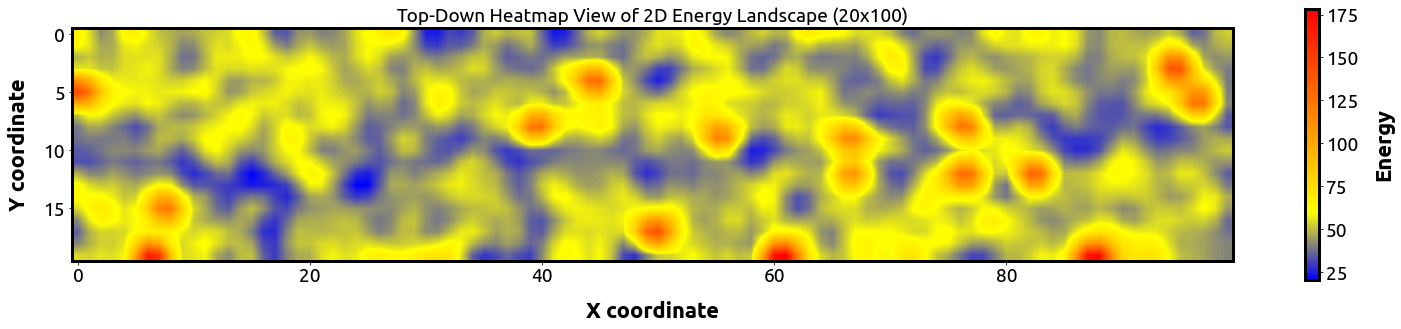

In [5]:

# Create a heatmap (top-down view) of the energy landscape
plt.figure(figsize=(26, 5))
cmap_name = 'RdYlBu_r'
plt.imshow(energy_landscape, cmap=nonlinear_custom_cmap, interpolation='bilinear')  # 'bilinear' for smoother appearance
# plt.imshow(energy_landscape, cmap=cmap_name) 
plt.colorbar(label='Energy')
plt.title('Top-Down Heatmap View of 2D Energy Landscape (20x100)')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.show()


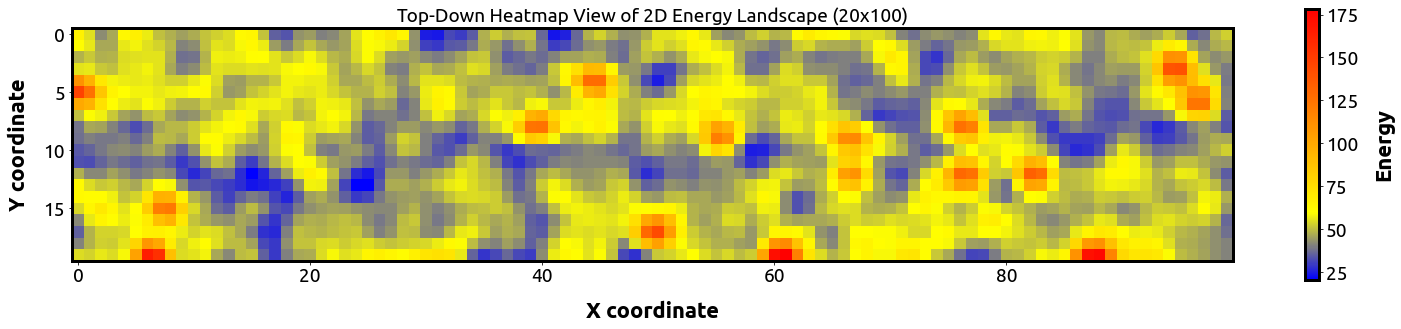

In [6]:

# Create a heatmap (top-down view) of the energy landscape
plt.figure(figsize=(26, 5))
cmap_name = 'RdYlBu_r'
plt.imshow(energy_landscape, cmap=nonlinear_custom_cmap, interpolation='nearest')  # 'bilinear' for smoother appearance
# plt.imshow(energy_landscape, cmap=cmap_name) 
plt.colorbar(label='Energy')
plt.title('Top-Down Heatmap View of 2D Energy Landscape (20x100)')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.show()


# Perform random walks on the landscape

In [9]:
# Parameters for the walks
num_replicates = 50  # Number of random walk replicates
temperature = 5
max_steps = 100

In [10]:
def simulate_random_walk(energy_landscape, height, width, temperature, max_steps):
    # Start from the leftmost column at a random row
    start_row = np.random.randint(height)
    start_col = 0  # Always start at the leftmost column
    walker_path = [(start_row, start_col)]
    current_row, current_col = start_row, start_col
    step_count = 0

    while step_count < max_steps:
        # Define possible next positions, including constraints for not moving left of the starting column
        next_positions = [
            (current_row, max(current_col + 1, 1)),  # Move right
            (current_row, max(current_col - 1, 0)),  # Move left, not beyond 0
            (np.clip(current_row - 1, 0, height - 1), current_col),  # Move up
            (np.clip(current_row + 1, 0, height - 1), current_col)  # Move down
        ]
        # Remove duplicates and positions that do not change (staying in place is allowed)
        next_positions = list(set(next_positions))

        # Get the energies for these positions
        next_energies = [energy_landscape[pos] for pos in next_positions]

        # Calculate probabilities inversely proportional to energy
        probabilities = np.exp(-np.array(next_energies) / temperature)
        probabilities /= probabilities.sum()  # Normalize to create a probability distribution

        # Choose the next position based on probabilities
        next_index = np.random.choice(range(len(next_positions)), p=probabilities)
        next_position = next_positions[next_index]

        # Update current position to the next
        current_row, current_col = next_position
        walker_path.append(next_position)
        step_count += 1

    return walker_path


In [11]:
def run_multiple_simulations(energy_landscape, num_replicates, height, width, temperature, max_steps):
    all_paths = []
    visit_count = np.zeros((height, width))
    for _ in range(num_replicates):
        path = simulate_random_walk(energy_landscape, height, width, temperature, max_steps)
        all_paths.append(path)
        for pos in path:
            visit_count[pos] += 1
    return all_paths, visit_count


In [12]:
def find_furthest_right_path(all_paths):
    # Initialize variables to track the furthest path
    max_x = -1
    furthest_right_path = None

    # Loop through all paths to find the one that extends furthest to the right
    for path in all_paths:
        max_path_x = max(pos[1] for pos in path)  # Extract the x-coordinate
        if max_path_x > max_x:
            max_x = max_path_x
            furthest_right_path = path

    return furthest_right_path

In [13]:
# Function to plot paths
def plot_paths(energy_landscape, paths, height, width, title='Random Walks on Energy Landscape'):
    cmap = LinearSegmentedColormap.from_list("custom_colormap", ["blue", "yellow", "red"])
    plt.figure(figsize=(26, 5))
    plt.imshow(energy_landscape, cmap=nonlinear_custom_cmap, interpolation='nearest', aspect='auto')
    plt.colorbar(label='Energy')

    for path in paths:
        plt.plot([pos[1] for pos in path], [pos[0] for pos in path], 'wo-', alpha=0.5)  # X is column, Y is row

    plt.title(title)
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.show()


In [14]:
all_paths,visit_matrix = run_multiple_simulations(energy_landscape, 50, 20, 100, 5, 10000)

In [15]:
big_path, big_visit_matrix = run_multiple_simulations(energy_landscape, 1, 20, 100, 5, 500000)


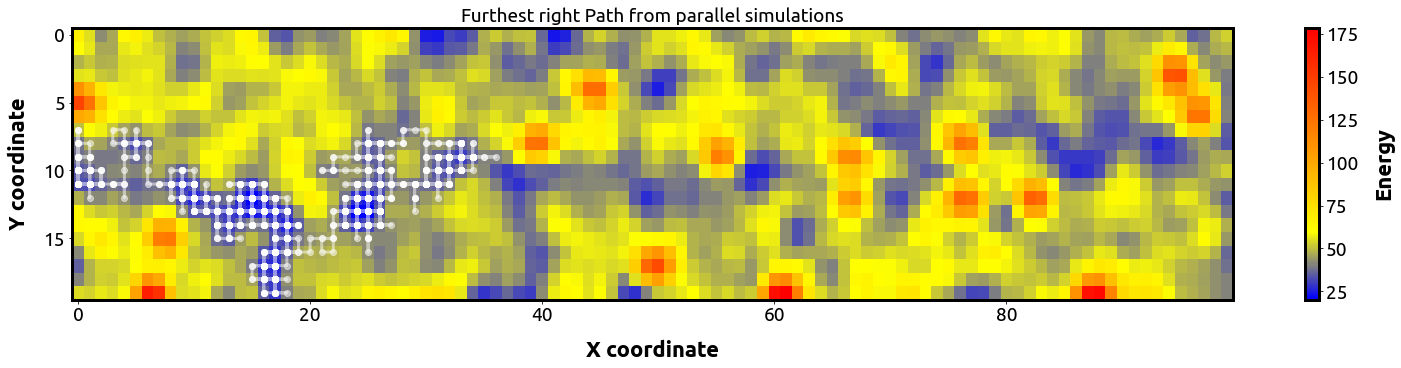

In [16]:
# Plot the path that made it furthest right
plot_paths(energy_landscape, [find_furthest_right_path(all_paths)], 20, 100, 'Furthest right Path from parallel simulations')
# plot_paths(energy_landscape, all_paths[:1], 20, 100)

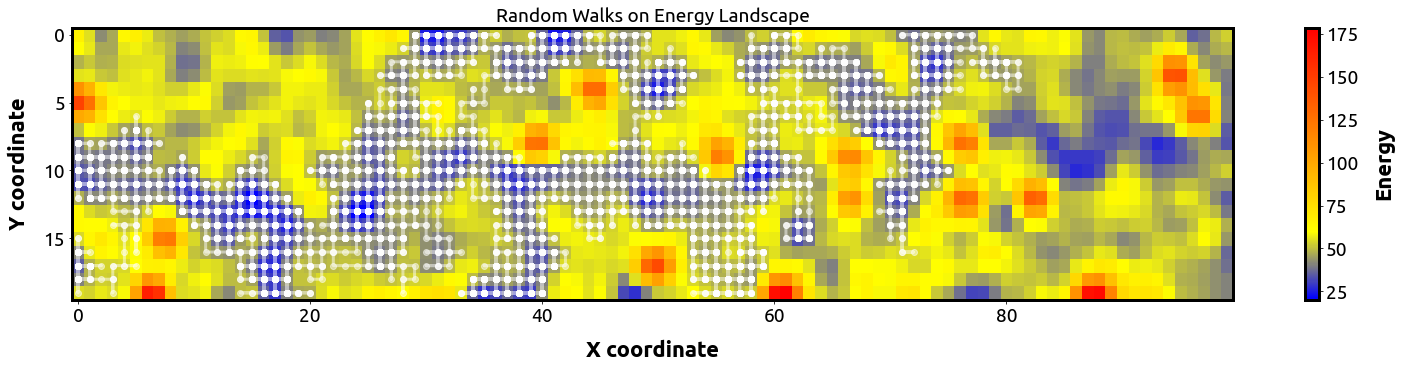

In [17]:
# Plot all paths
plot_paths(energy_landscape, big_path[:1], 20, 100)

# Do rounds of replicates rather than unique replicates

In [18]:
def simulate_rounded_random_walks(energy_landscape, rounds, replicates_per_round, steps_per_walk, temperature):
    height, width = energy_landscape.shape
    visit_matrix = np.zeros_like(energy_landscape)  # Initialize the visit matrix
    current_positions = [(np.random.randint(height), 0) for _ in range(replicates_per_round)]  # Start all walkers at x=0
    
    all_paths = []

    for _ in range(rounds):
        round_paths = []
        new_positions = []

        for start_pos in current_positions:
            current_row, current_col = start_pos
            walker_path = [start_pos]
            visit_matrix[current_row, current_col] += 1  # Record the visit to the start position

            for _ in range(steps_per_walk):
                next_positions = [
                    (current_row, max(current_col - 1, 0)),  # Left, not beyond 0
                    (current_row, min(current_col + 1, width - 1)),  # Right
                    (np.clip(current_row - 1, 0, height - 1), current_col),  # Up
                    (np.clip(current_row + 1, 0, height - 1), current_col)  # Down
                ]
                next_positions = list(set(next_positions))  # Remove duplicates
                next_energies = [energy_landscape[pos] for pos in next_positions]
                probabilities = np.exp(-np.array(next_energies) / temperature)
                probabilities /= probabilities.sum()
                next_index = np.random.choice(range(len(next_positions)), p=probabilities)
                next_position = next_positions[next_index]

                current_row, current_col = next_position
                walker_path.append(next_position)
                visit_matrix[current_row, current_col] += 1  # Record the visit

            round_paths.append(walker_path)
            new_positions.append((current_row, current_col))  # Save the last position as the next starting position

        all_paths.extend(round_paths)
        current_positions = new_positions  # Update starting positions for the next round

    return all_paths, visit_matrix

In [19]:
fah_paths, fah_visit_matrix = simulate_rounded_random_walks(energy_landscape, 5, 10, 10000, 5)

In [21]:
# You might want to plot or analyze these paths further; for example, here is how to plot all paths:
def plot_all_paths(landscape, all_paths):
    cmap = LinearSegmentedColormap.from_list("custom_colormap", ["blue", "yellow", "red"])
    plt.figure(figsize=(26, 5))
    plt.imshow(landscape, cmap=cmap, interpolation='nearest', aspect='auto')
    plt.colorbar(label='Energy')
    
    for path in all_paths:
        plt.plot([pos[1] for pos in path], [pos[0] for pos in path], 'w-', alpha=0.1)  # Using low alpha for clarity
    
    plt.title('All Paths Across Rounds')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.show()

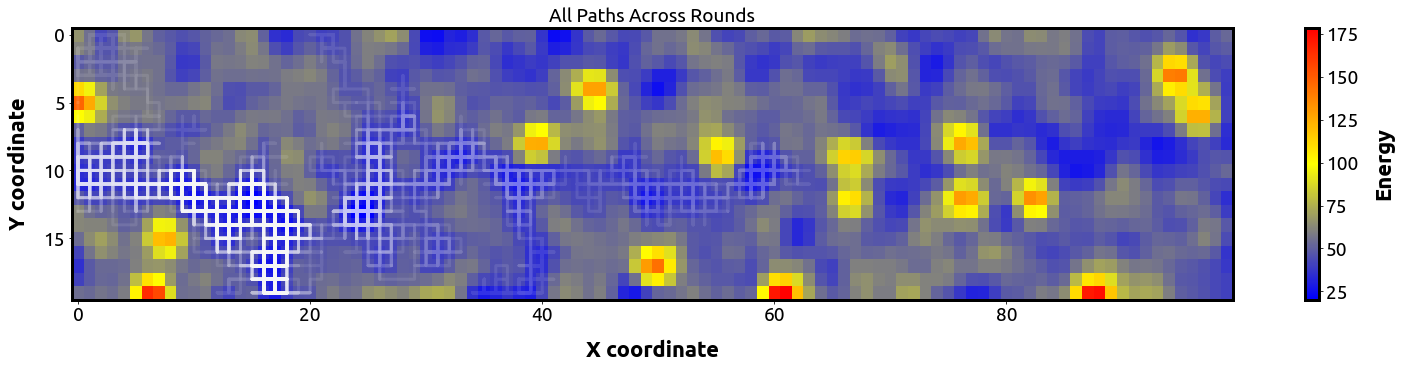

In [22]:
plot_all_paths(energy_landscape, fah_paths)

# Plot Visit frequencies

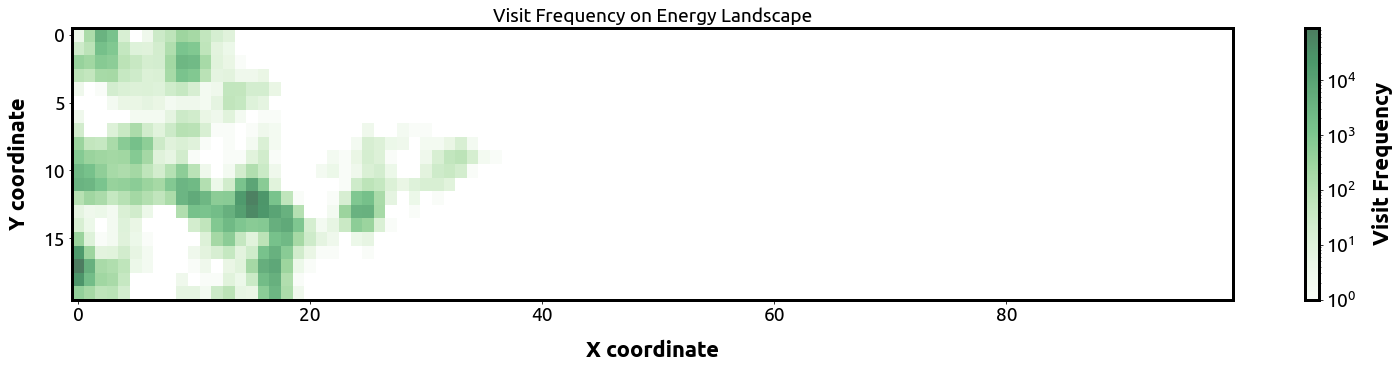

In [23]:
# Plotting
plt.figure(figsize=(26, 5))
# plt.imshow(energy_landscape, cmap=custom_cmap, interpolation='nearest', aspect='auto')
# plt.colorbar(label='Energy')
plt.imshow(visit_matrix, cmap="Greens", interpolation='nearest', aspect='auto', alpha=0.7, norm=LogNorm())
plt.colorbar(label='Visit Frequency')
plt.title('Visit Frequency on Energy Landscape')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.show()


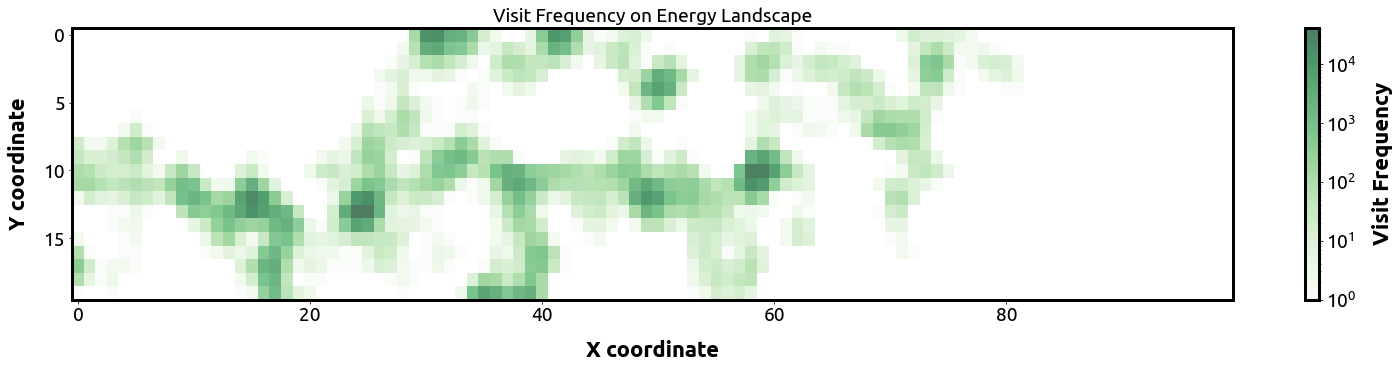

In [24]:
# Plotting
plt.figure(figsize=(26, 5))
# plt.imshow(energy_landscape, cmap=custom_cmap, interpolation='nearest', aspect='auto')
# plt.colorbar(label='Energy')
plt.imshow(big_visit_matrix, cmap="Greens", interpolation='nearest', aspect='auto', alpha=0.7, norm=LogNorm())
plt.colorbar(label='Visit Frequency')
plt.title('Visit Frequency on Energy Landscape')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.show()


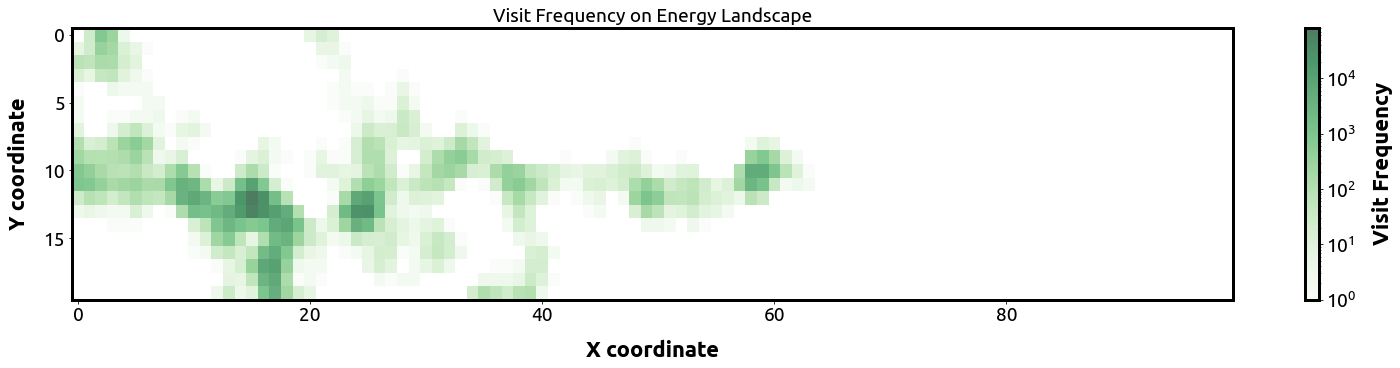

In [28]:
# Plotting
plt.figure(figsize=(26, 5))
# plt.imshow(energy_landscape, cmap=custom_cmap, interpolation='nearest', aspect='auto')
# plt.colorbar(label='Energy')
plt.imshow(fah_visit_matrix, cmap="Greens", interpolation='nearest', aspect='auto', alpha=0.7, norm=LogNorm())
plt.colorbar(label='Visit Frequency')
plt.title('Visit Frequency on Energy Landscape')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.show()


## Plot all at once

/tmp/ipykernel_426354/3272065229.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


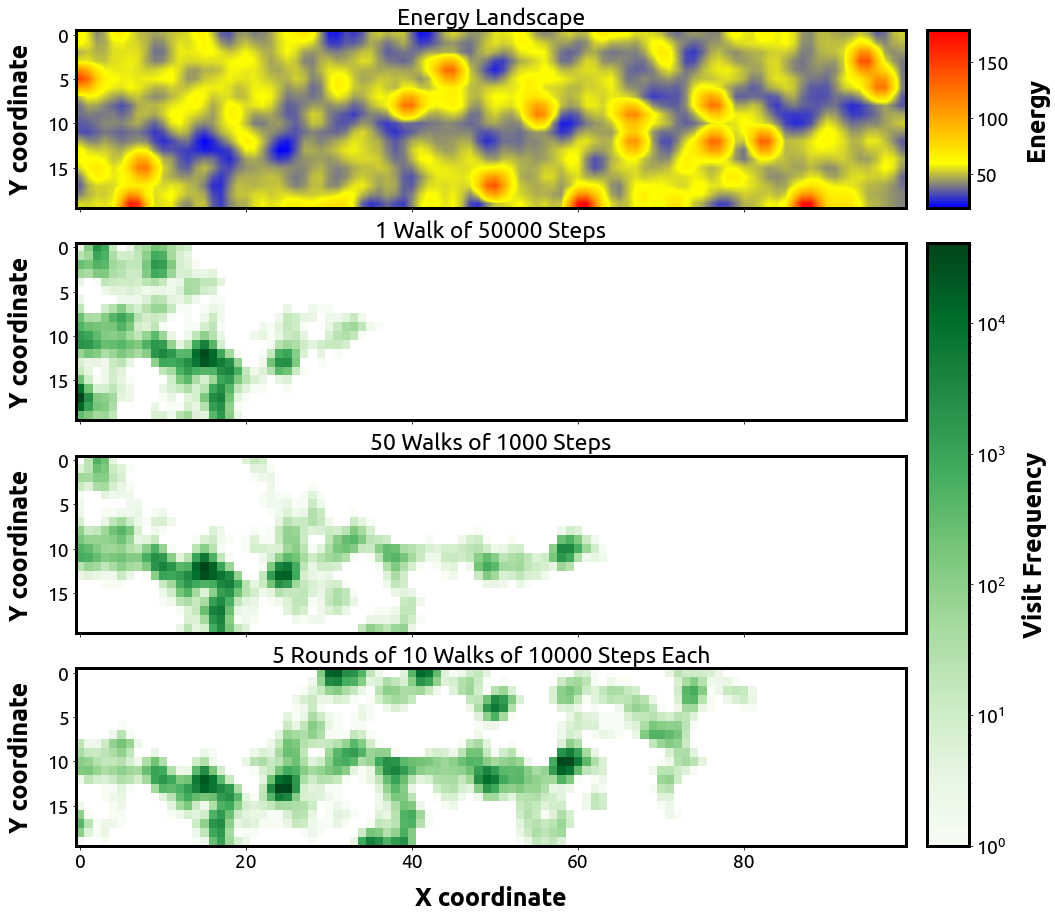

In [49]:
# Create a figure with custom subplot configuration
fig = plt.figure(figsize=(16,15))
fig.patch.set_facecolor('white') 
gs = gridspec.GridSpec(4, 2, width_ratios=[20, 1], wspace=0.05)

# Define the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_colormap", ["blue", "yellow", "red"])

# Energy landscape with its own color bar
ax0 = plt.subplot(gs[0, 0])
im0 = ax0.imshow(energy_landscape, cmap=nonlinear_custom_cmap, interpolation='bilinear', aspect='auto')
ax0.set_title('Energy Landscape')
ax0.set_ylabel('Y coordinate')
ax0.set_xticklabels([])
cax0 = plt.subplot(gs[0, 1])
plt.colorbar(im0, cax=cax0, label='Energy')

# Visitation matrix from one long walk
ax1 = plt.subplot(gs[1, 0])
im1 = ax1.imshow(visit_matrix, cmap='Greens', interpolation='nearest', aspect='auto', norm=LogNorm())
ax1.set_title('1 Walk of 50000 Steps')
ax1.set_xticklabels([])
ax1.set_ylabel('Y coordinate')

# Visitation matrix from multiple short walks
ax2 = plt.subplot(gs[2, 0])
im2 = ax2.imshow(fah_visit_matrix, cmap='Greens', interpolation='nearest', aspect='auto', norm=LogNorm())
ax2.set_title('50 Walks of 1000 Steps')
# disable x-tick labels for this subplot
ax2.set_xticklabels([])
ax2.set_ylabel('Y coordinate')

# Visitation matrix from rounds of walks
ax3 = plt.subplot(gs[3, 0])
im3 = ax3.imshow(big_visit_matrix, cmap='Greens', interpolation='nearest', aspect='auto', norm=LogNorm())
ax3.set_title('5 Rounds of 10 Walks of 10000 Steps Each')
ax3.set_xlabel('X coordinate')
ax3.set_ylabel('Y coordinate')

# Shared color bar for visitation matrices
cax_shared = plt.subplot(gs[1:4, 1])  # Spanning from index 1 to 3
# make a thin color bar
plt.colorbar(im3, cax=cax_shared, label='Visit Frequency')

plt.tight_layout()
plt.savefig("figures/energy_landscape_walks.png", dpi=300, bbox_inches="tight")

# Try to animate it

## Plot animation of the visitation matrix over time

In [524]:
from matplotlib.animation import FuncAnimation

ani_visit_matrix = np.zeros_like(energy_landscape, dtype=int)
def update(frame):
    global ani_visit_matrix
    print(f"Updating frame {frame}")  # Debug: Print current frame number
    start_row = np.random.randint(energy_landscape.shape[0])
    path = simulate_random_walk(energy_landscape, 20, 100, 5, 1000)

    for pos in path:
        ani_visit_matrix[pos] += 1

    im.set_data(ani_visit_matrix)
    im.set_norm(LogNorm(vmin=1, vmax=ani_visit_matrix.max()))
    print(f"Max visits: {ani_visit_matrix.max()}")  # Debug: Check if visits are increasing
    return (im,)

Updating frame 0
Max visits: 33459


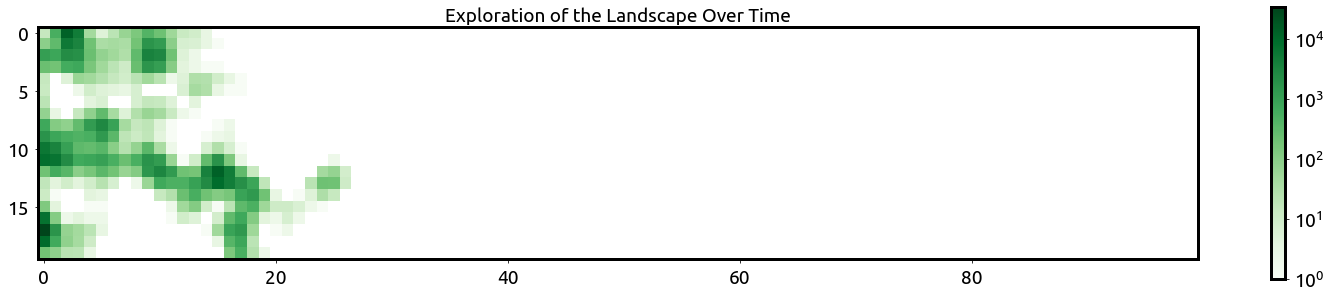

Updating frame 0
Max visits: 33459
Updating frame 0
Max visits: 33459
Updating frame 1
Max visits: 34090
Updating frame 2
Max visits: 34090
Updating frame 3
Max visits: 34700
Updating frame 4
Max visits: 34700
Updating frame 5
Max visits: 35334
Updating frame 6
Max visits: 35334
Updating frame 7
Max visits: 35948
Updating frame 8
Max visits: 36585
Updating frame 9
Max visits: 36585
Updating frame 10
Max visits: 36585
Updating frame 11
Max visits: 36585
Updating frame 12
Max visits: 36585
Updating frame 13
Max visits: 36585
Updating frame 14
Max visits: 36585
Updating frame 15
Max visits: 36585
Updating frame 16
Max visits: 36585
Updating frame 17
Max visits: 36585
Updating frame 18
Max visits: 36585
Updating frame 19
Max visits: 36585
Updating frame 20
Max visits: 37208
Updating frame 21
Max visits: 37820
Updating frame 22
Max visits: 37820
Updating frame 23
Max visits: 37820
Updating frame 24
Max visits: 37820
Updating frame 25
Max visits: 38456
Updating frame 26
Max visits: 39037
Upd

KeyboardInterrupt: 

In [535]:
fig, ax = plt.subplots(figsize=(26, 5))
im = ax.imshow(ani_visit_matrix, interpolation='nearest', cmap='Greens', norm=LogNorm(vmin=1, vmax=1))
ax.set_title('Exploration of the Landscape Over Time')
plt.colorbar(im, ax=ax)

# Create the animation
ani = FuncAnimation(fig, update, frames=50000, blit=True, repeat=True)
plt.show()

# Optionally, save the animation
ani.save('landscape_exploration.mp4', writer='ffmpeg', fps=30)

## Plot animation of the path accumulation over time

In [557]:
path_matrix = np.zeros_like(energy_landscape)  # Matrix to store path visits


In [558]:
def update(frame):
    """ Update the plot with new paths """
    start_row = np.random.randint(energy_landscape.shape[0])  # Random start row at x=0
    path = simulate_random_walk(energy_landscape, 20, 100, 5, 1000)
    # Mark each position in the path in the path_matrix
    for pos in path:
        path_matrix[pos] = 1  # Mark this cell as visited

    im.set_data(path_matrix)  # Update the image data
    return [im]


Text(0.5, 1.0, 'Exploration of the Landscape Over Time')

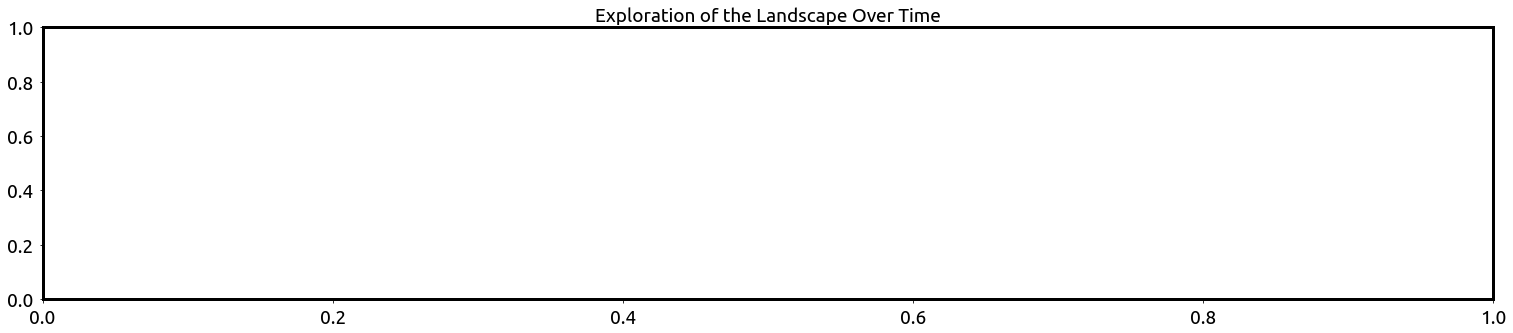

In [559]:
from matplotlib.animation import FuncAnimation

# Initialize the plot
fig, ax = plt.subplots(figsize=(26,5))
# im = ax.imshow(energy_landscape, cmap=nonlinear_custom_cmap, interpolation='nearest', aspect='auto')
ax.set_title('Exploration of the Landscape Over Time')

In [560]:
# Create the animation
ani = FuncAnimation(fig, update, frames=200, blit=True, repeat=True)
plt.show()

In [561]:
ani.save('path_exploration.mp4', writer='ffmpeg', fps=5)

Frame 0: Updating...
Max in path_matrix: 1


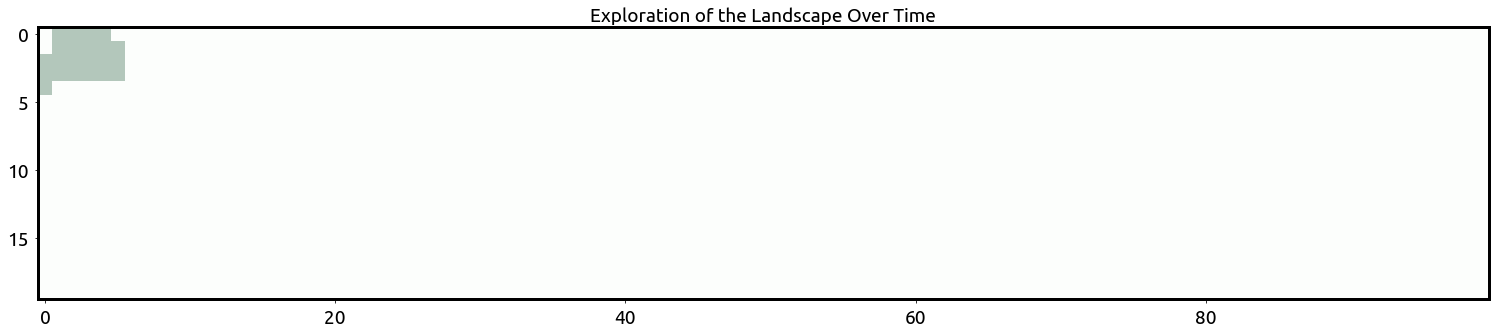

In [575]:
path_matrix = np.zeros_like(energy_landscape, dtype=int)  # Initialize path matrix

fig, ax = plt.subplots(figsize=(26,5))
# Ensure the colormap shows change when path_matrix updates from 0 to 1
# cmap = LinearSegmentedColormap.from_list("custom_cmap", ['white', 'purple'])
im = ax.imshow(path_matrix, cmap="Greens", interpolation='nearest', aspect='auto', 
               vmin=0, vmax=1, alpha=0.3)
ax.set_title('Exploration of the Landscape Over Time')

def update(frame):
    print(f"Frame {frame}: Updating...")  # Debug statement
    start_row = np.random.randint(energy_landscape.shape[0])  # Random start row
    path = simulate_random_walk(energy_landscape, 20, 100, 5, 1000)  # Simulate a longer walk

    for pos in path:
        path_matrix[pos] = 1  # Mark the cell as visited

    print(f"Max in path_matrix: {np.max(path_matrix)}")  # Should print 1 after first frame
    im.set_data(path_matrix)
    return [im]

ani = FuncAnimation(fig, update, frames=200, blit=True, repeat=False)  # Reduced frames for testing

plt.show()


In [576]:
ani.save('path_exploration.mp4', writer='ffmpeg', fps=5)

Frame 0: Updating...
Max in path_matrix: 1
Frame 0: Updating...
Max in path_matrix: 1
Frame 1: Updating...
Max in path_matrix: 1
Frame 2: Updating...
Max in path_matrix: 1
Frame 3: Updating...
Max in path_matrix: 1
Frame 4: Updating...
Max in path_matrix: 1
Frame 5: Updating...
Max in path_matrix: 1
Frame 6: Updating...
Max in path_matrix: 1
Frame 7: Updating...
Max in path_matrix: 1
Frame 8: Updating...
Max in path_matrix: 1
Frame 9: Updating...
Max in path_matrix: 1
Frame 10: Updating...
Max in path_matrix: 1
Frame 11: Updating...
Max in path_matrix: 1
Frame 12: Updating...
Max in path_matrix: 1
Frame 13: Updating...
Max in path_matrix: 1
Frame 14: Updating...
Max in path_matrix: 1
Frame 15: Updating...
Max in path_matrix: 1
Frame 16: Updating...
Max in path_matrix: 1
Frame 17: Updating...
Max in path_matrix: 1
Frame 18: Updating...
Max in path_matrix: 1
Frame 19: Updating...
Max in path_matrix: 1
Frame 20: Updating...
Max in path_matrix: 1
Frame 21: Updating...
Max in path_matrix: 1

## Plot path generation over time in sequence

In [604]:
def update(frame):
    global path_lines
    if frame == 0:
        # Start a new path
        path = simulate_random_walk(energy_landscape, 20, 100, 5, 1000)  # Moderate temperature, arbitrary steps
        x, y = zip(*path)
        path_lines.set_data(y, x)  # Update line data
    return path_lines,

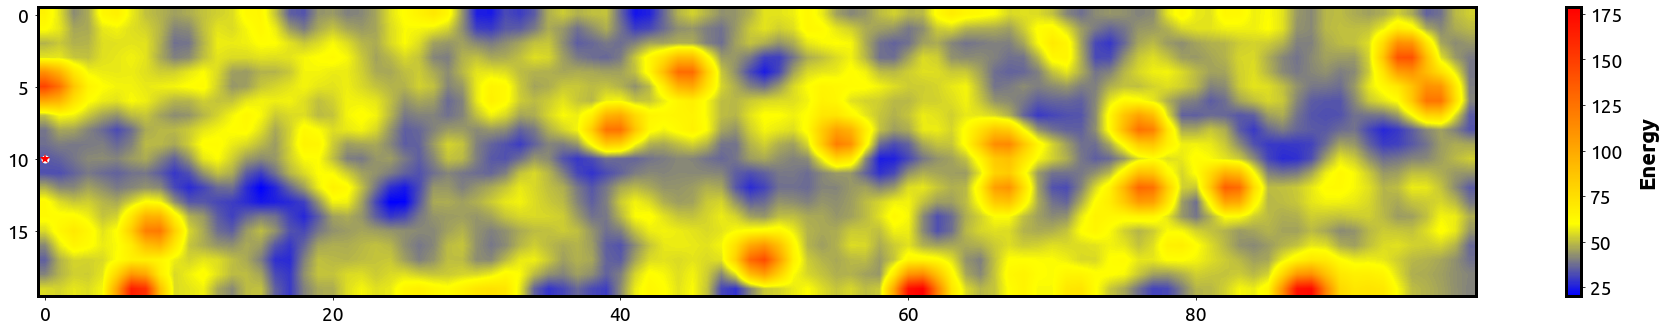

In [637]:
height, width = 20, 100

fig, ax = plt.subplots(figsize=(26, 5))
ax.set_title('Exploration of the Landscape Over Time')
im = ax.imshow(energy_landscape, cmap=nonlinear_custom_cmap, interpolation='bilinear', aspect='auto')
path_lines, = ax.plot([], [], 'o-', c="white",markersize=8)  # Initialize a line object for the path
end_marker, = ax.plot([], [], '*',c="red", markeredgecolor='black',  markersize=10)  # Red marker for the end of the path
plt.colorbar(im, label='Energy')


def simulate_random_walk(energy_landscape, height, width, temperature, max_steps):
    # start_row = np.random.randint(height)
    start_row = 10
    start_col = 0  # Always start at the leftmost column
    walker_path = [(start_row, start_col)]
    current_row, current_col = start_row, start_col

    for _ in range(max_steps):
        next_positions = [
            (current_row, max(current_col + 1, 1)),  # Right
            (current_row, max(current_col - 1, 0)),  # Left, not beyond 0
            (np.clip(current_row - 1, 0, height - 1), current_col),  # Up
            (np.clip(current_row + 1, 0, height - 1), current_col)  # Down
        ]
        next_positions = list(set(next_positions))
        next_energies = [energy_landscape[pos] for pos in next_positions]
        probabilities = np.exp(-np.array(next_energies) / temperature)
        probabilities /= probabilities.sum()
        next_index = np.random.choice(range(len(next_positions)), p=probabilities)
        next_position = next_positions[next_index]

        current_row, current_col = next_position
        walker_path.append(next_position)

    return walker_path

path = simulate_random_walk(energy_landscape, height, width, 10, 1000)  # Generate a path

def update(frame):
    if frame == len(path):
        return path_lines,  # Stop the animation after all steps are shown

    # Extract coordinates up to the current frame
    x, y = zip(*path[:frame + 1])
    path_lines.set_data(y, x)

    # Mark the end of the path with a red marker
    # Update the position of the end marker to the last point of the path
    end_marker.set_data(y[-1], x[-1])

    return path_lines,

ani = FuncAnimation(fig, update, frames=len(path) + 1, blit=True, repeat=False)
fig.tight_layout()
plt.show()

In [638]:
ani.save('path_exploration.mp4', writer='ffmpeg', fps=24)